0


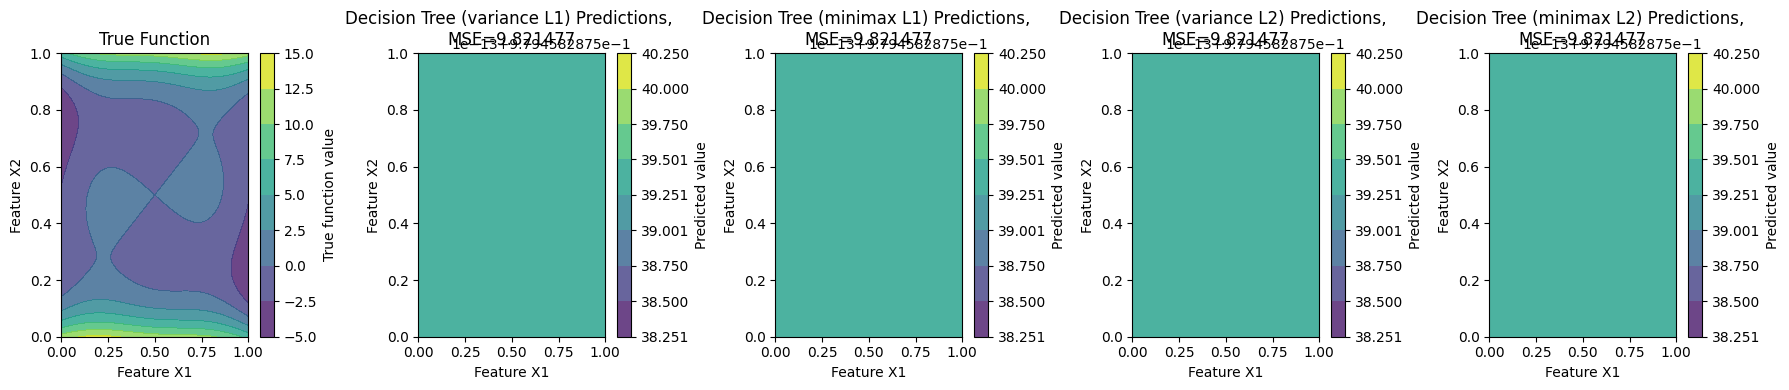

1


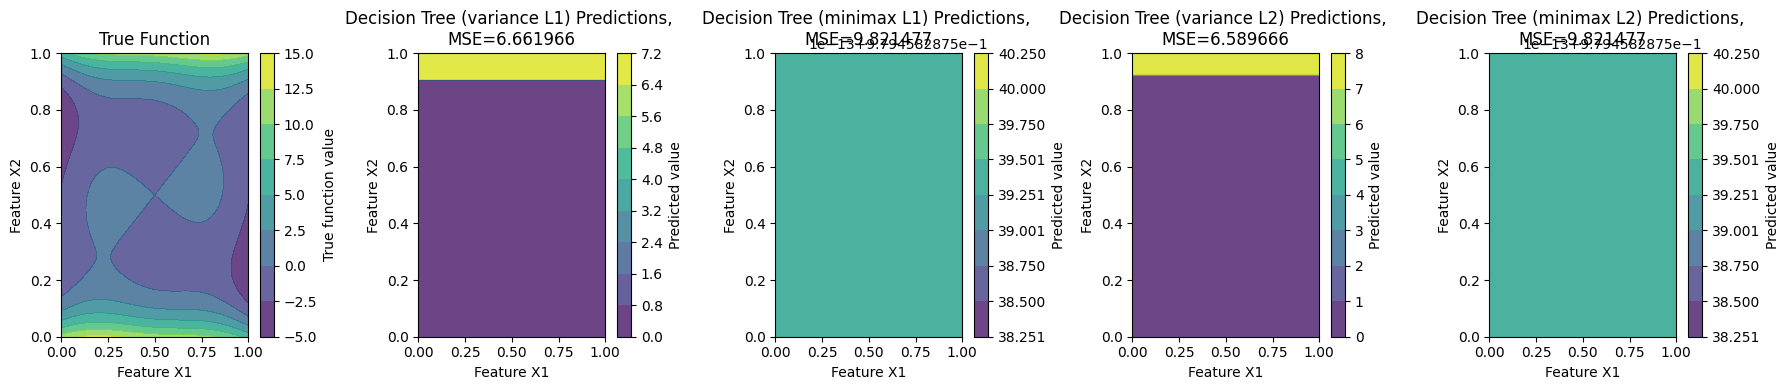

2


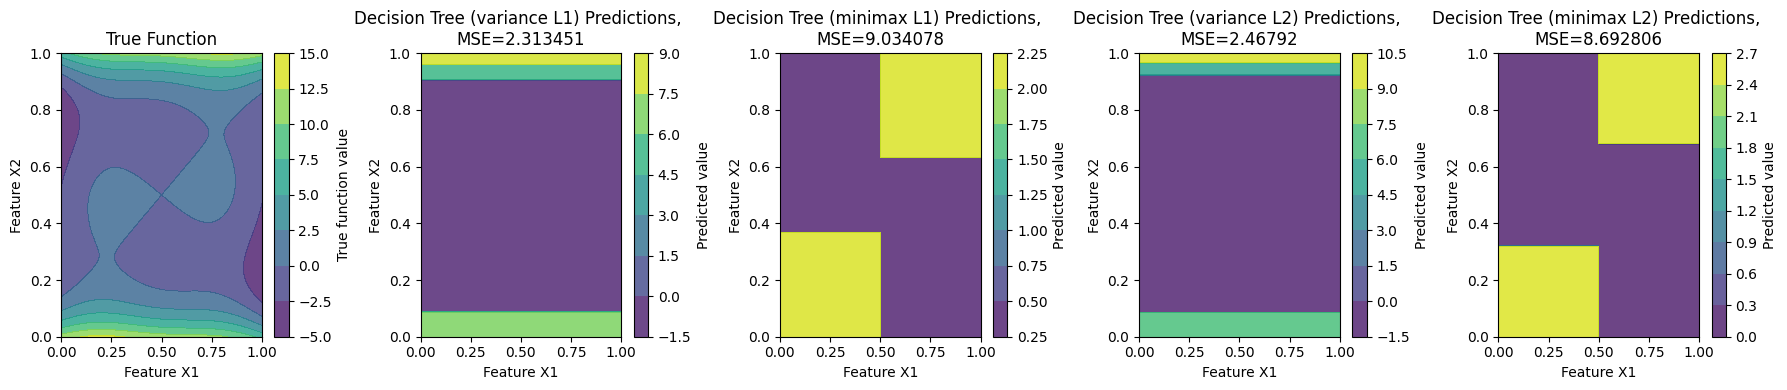

3


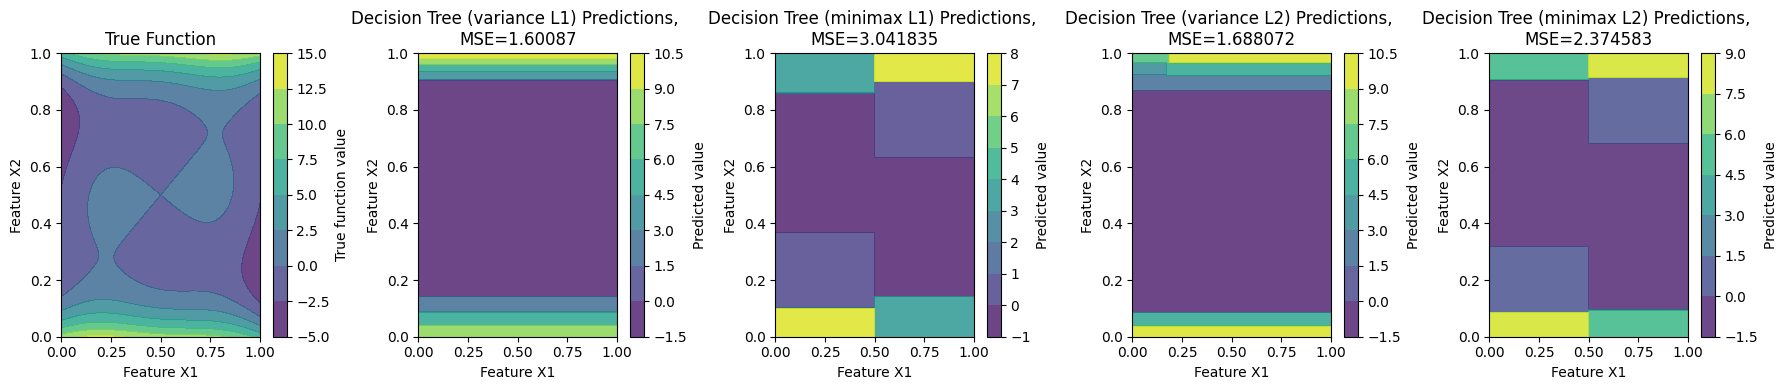

4


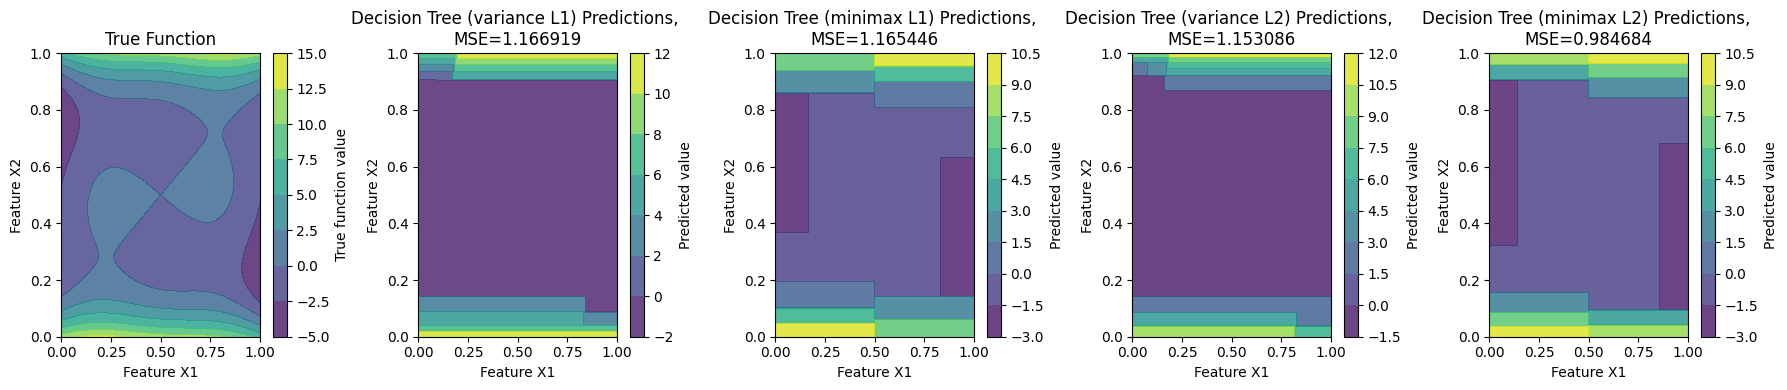

5


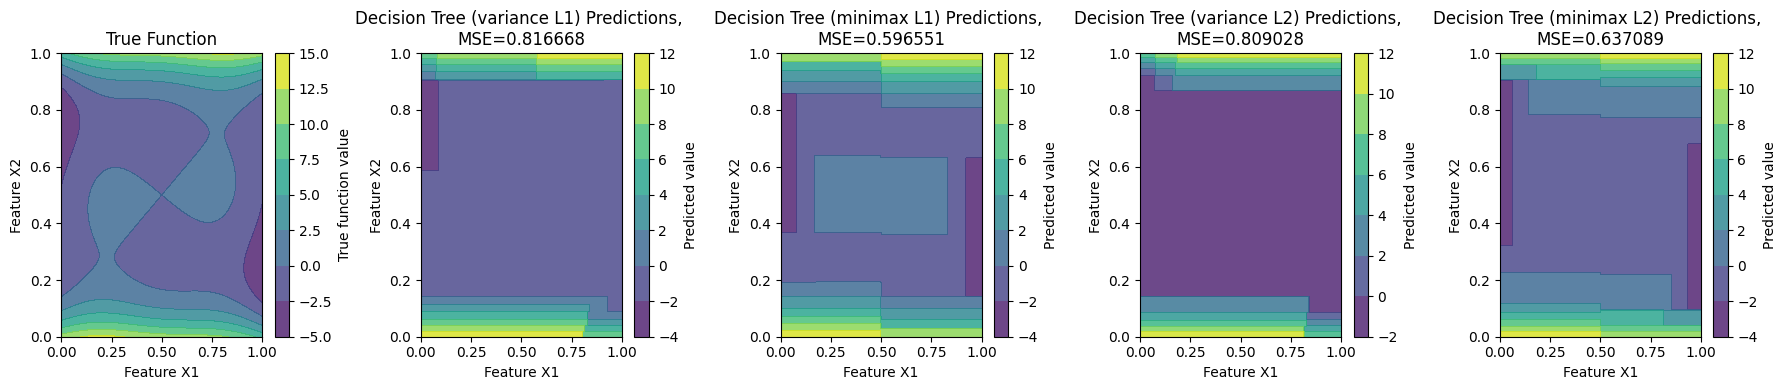

6


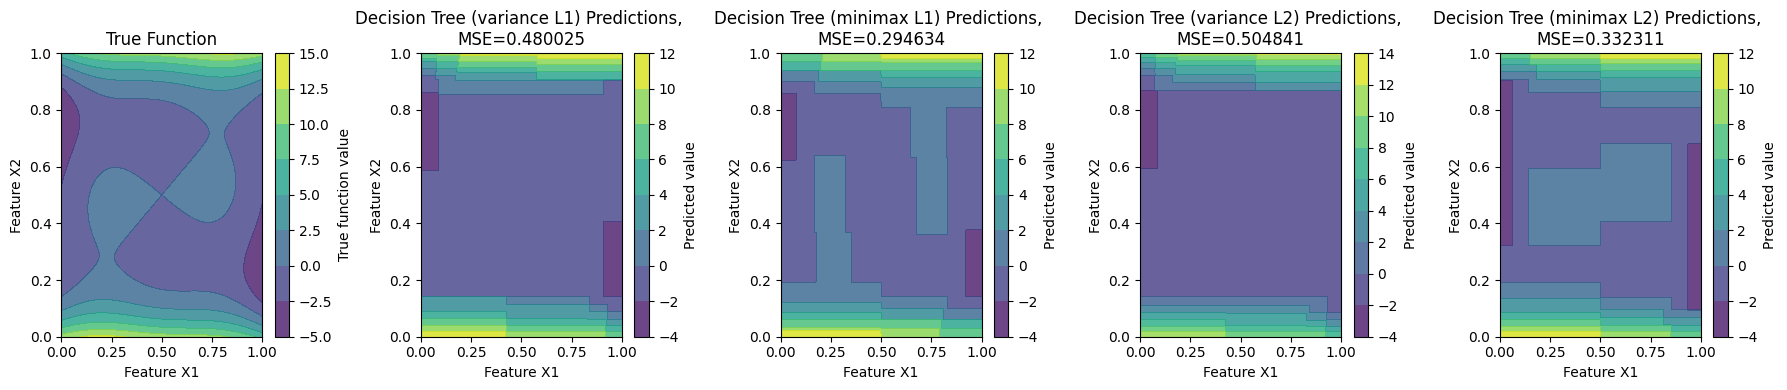

7


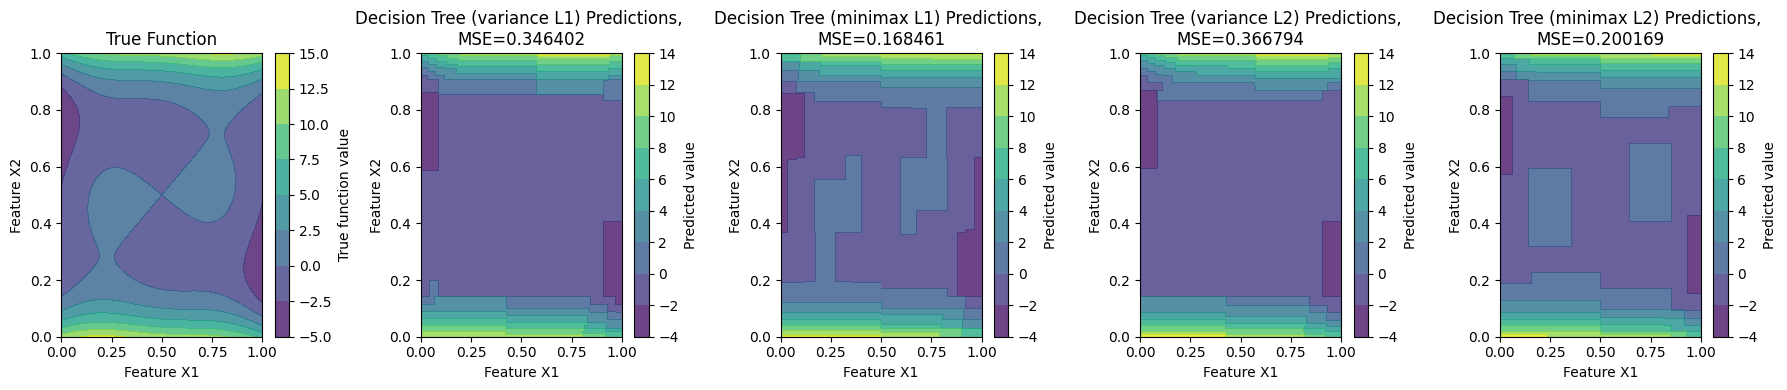

8


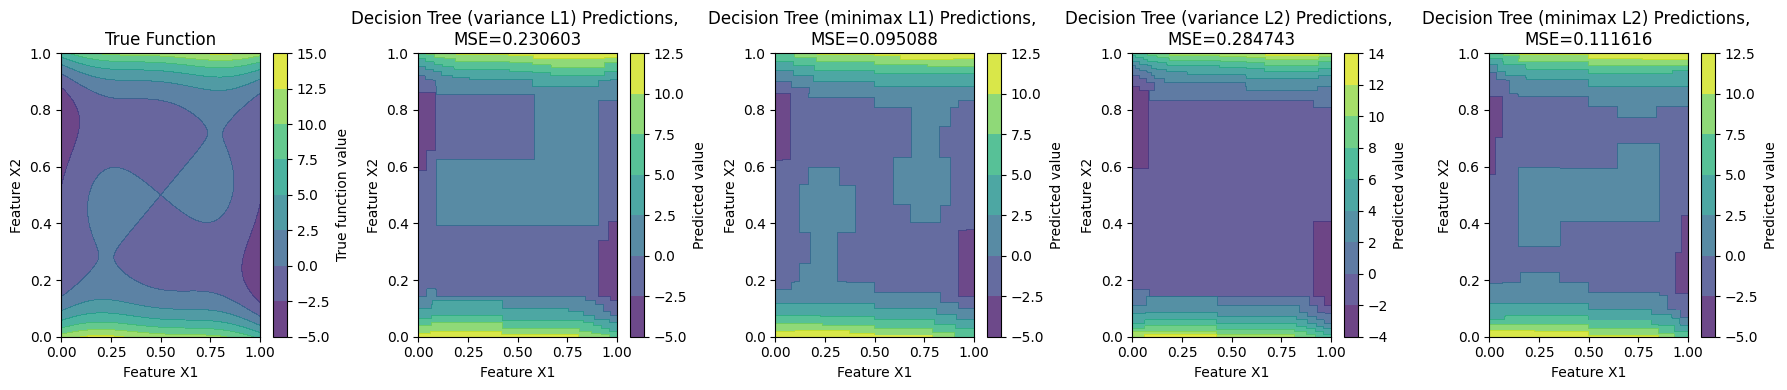

9


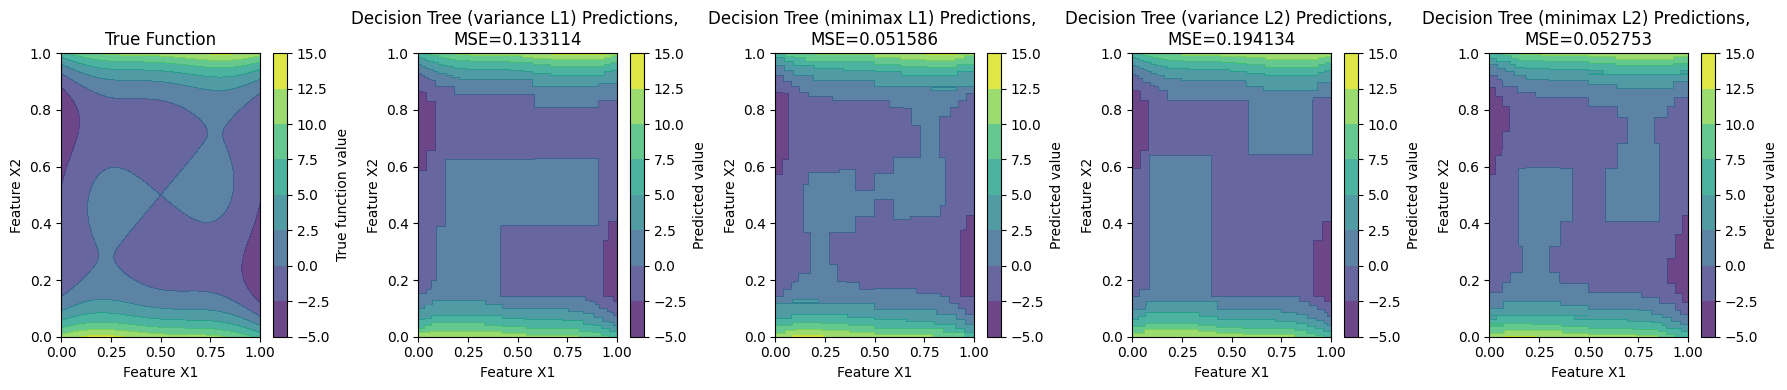

10


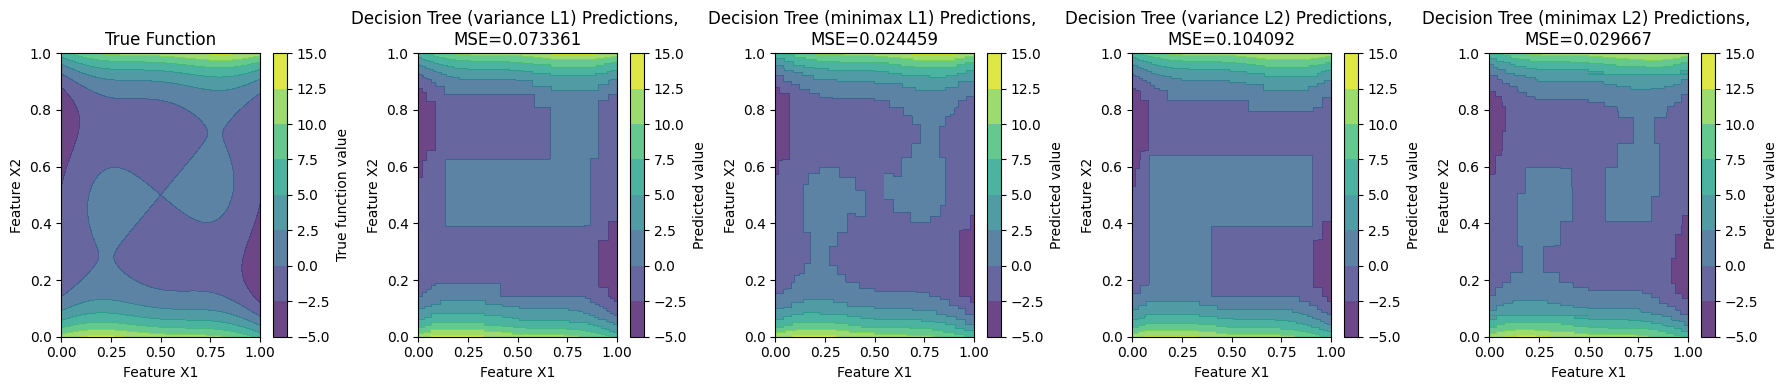

11


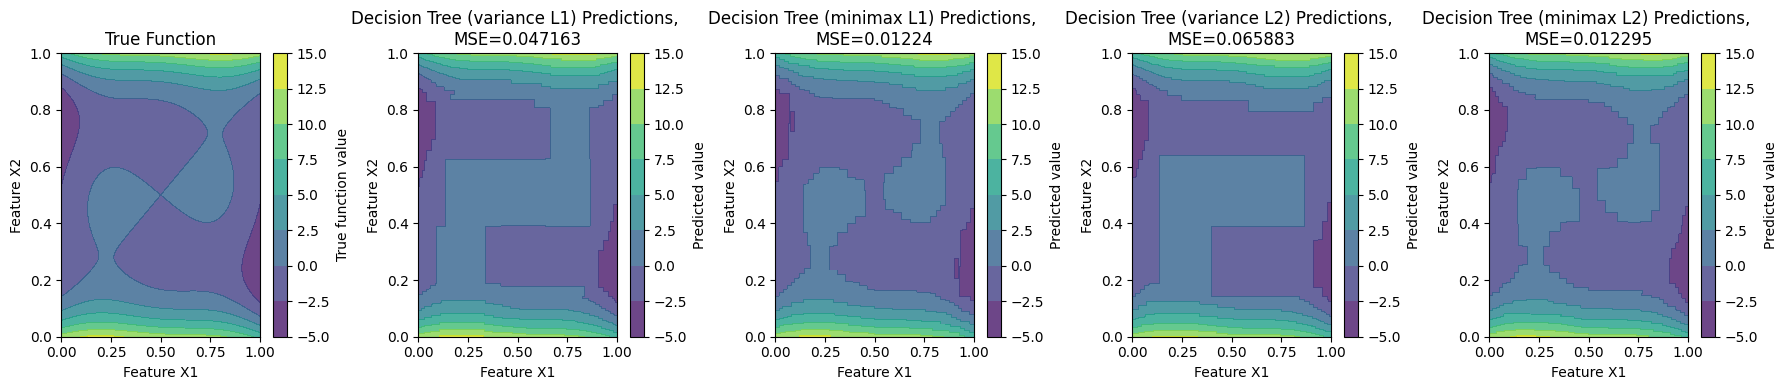

12


KeyboardInterrupt: 

In [1]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=float('inf'), error_method='variance', cyclic_padding=0, loss_norm=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.error_method = error_method
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left == None and self.right == None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        if self.error_method == 'cyclic_minimax':
            best_split = self.cyclic_minimax_split(X, y, depth)
        else:
            best_split = self.find_best_split(X, y)

        best_feature, best_threshold = best_split
        if best_split is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    def find_best_split(self, X, y):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            index, threshold, error = self.evaluate_splits(X, y, feature_index)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold

        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding+depth) % num_features
        ###print('cyclic index ',feature_index)
        best_feature, best_threshold, _ = self.evaluate_splits(X, y, feature_index)
        best_feature = feature_index
        return best_feature, best_threshold

    def evaluate_splits(self, X, y, feature_index):
        if self.error_method == 'median_X':
            threshold = np.median(X[:, feature_index])
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        elif self.error_method == 'median_y':
            median_y_value = np.median(y)
            index = np.argsort(np.abs(y - median_y_value))[0]
            threshold = X[index, feature_index]
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        else:
            thresholds = np.unique(X[:, feature_index])
            min_error = float('inf')
            best_threshold = None
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices
                error = self.calculate_error(y, left_indices, right_indices) 
                if error < min_error:
                    min_error = error
                    best_threshold = threshold
            return feature_index, best_threshold, min_error
    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            # Max norm (L-infinity) handling
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            # General p-norm
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)
    def calculate_error(self, y, left_indices, right_indices):
        if sum(left_indices)<=1 or sum(left_indices) is None:
            return np.inf
        if sum(right_indices)<=1 or sum(right_indices) is None:
            return np.inf 
        left_error = right_error = 0
        if self.error_method == 'variance':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return left_error+right_error
        elif self.error_method == 'minimax' or self.error_method == 'cyclic_minimax':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return max(left_error, right_error)
        elif self.error_method == 'weighted_variance':
            left_error = sum(left_indices) * ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = sum(right_indices) * ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            return left_error+right_error
        return left_error + right_error

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def prune(self, node=None):
        if node is None:
            node = self.root

        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            original_complexity = original_error + complexity_alpha*self.count_leaves()
            pruned_complexity = pruned_error + complexity_alpha*self.count_leaves()
            if pruned_complexity > original_complexity:
                node.is_leaf = False
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root

        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)





""" # Create some sample data
np.random.seed(1)
X = np.linspace(-2, 2, 100).reshape(-1, 1)
X_new = np.linspace(-3, 3, 1000).reshape(-1, 1)
shared_noise_var = 0.1

def f_truth(X,noise_var=0.01):
    return  np.sin(X.ravel()*2) + np.random.randn(X.ravel().shape[0]) * noise_var

y = f_truth(X,shared_noise_var)
y_new = f_truth(X_new,shared_noise_var)

# Instantiate and train the decision tree
tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3,error_method='variance')
tree.root = tree.fit(X, y)
tree.print_tree()
num_leaves = tree.count_leaves()
print(f"The number of leaves in the tree: {num_leaves}")
print('-'*100)
#tree.prune()
#tree.print_tree()
#num_leaves = tree.count_leaves()
#print(f"The number of leaves in the tree: {num_leaves}")

# Make predictions
predictions = tree.predict(X_new)

# Plotting the results
import matplotlib.pyplot as plt """
""" plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_new, predictions, color='red', label='Decision Tree Predictions')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Decision Tree Regression Example, MSE='+str(np.mean((predictions-y_new)**2) ))
plt.legend()
plt.show() """



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)

# Generating a 2D grid of features
x1 = np.linspace(0, 1, 600)
x2 = np.linspace(0, 1, 600)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

# Define a function that depends on X1 and X2
def f_truth(X, noise_var=0):
    x1 = (X[:,0] -.5)*3
    x2 = (X[:,1] -.5)*3
    return (2-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2

y = f_truth(X)

vari1=[]
mini1=[]
vari2=[]
mini2=[]

logvari=[]
logmini=[]
for depth in range(20):
    print(depth)
    # Prepare the mesh grid for predictions and visualization
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_new = f_truth(X_new)  # Slightly less noise for cleaner function visualization
    # Assuming the DecisionTreeRegressor class has already been imported and is available
    tree1 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=1)
    tree1.root = tree1.fit(X, y)
    # Make predictions on the grid
    predictions1 = tree1.predict(X_new)
    predictions1 = np.asarray(predictions1).reshape(X1.shape)  # Reshape to 2D grid
    logvari.append(np.log(np.mean((predictions1.ravel()-y_new)**2)))
    vari1.append(np.mean((predictions1.ravel()-y_new)**2))

    tree2 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=1)
    tree2.root = tree2.fit(X, y)
    # Make predictions on the grid
    predictions2 = tree2.predict(X_new)
    predictions2 = np.asarray(predictions2).reshape(X1.shape)  # Reshape to 2D grid
    mini1.append(np.mean((predictions2.ravel()-y_new)**2))

    tree3 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=2)
    tree3.root = tree3.fit(X, y)
    # Make predictions on the grid
    predictions3 = tree3.predict(X_new)
    predictions3 = np.asarray(predictions3).reshape(X1.shape)  # Reshape to 2D grid
    vari2.append(np.mean((predictions3.ravel()-y_new)**2))

    tree4 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=2)
    tree4.root = tree4.fit(X, y)
    # Make predictions on the grid
    predictions4 = tree4.predict(X_new)
    predictions4 = np.asarray(predictions4).reshape(X1.shape)  # Reshape to 2D grid
    mini2.append(np.mean((predictions4.ravel()-y_new)**2))

    # Plotting the original data and the decision tree approximation
    plt.figure(figsize=(18, 4))

    # Original function plot
    plt.subplot(1, 5, 1)
    plt.contourf(X1, X2, y_new.reshape(X1.shape), cmap='viridis', alpha=0.8)
    plt.colorbar(label='True function value')
    plt.title('True Function')
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')

    # Decision tree predictions plot
    plt.subplot(1, 5, 2)
    plt.contourf(X1, X2, predictions1, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Predicted value')
    plt.title('Decision Tree (variance L1) Predictions, \nMSE='+str(np.round(np.mean((predictions1.ravel()-y_new)**2) ,6)) )
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')

    # Decision tree predictions plot
    plt.subplot(1, 5, 3)
    plt.contourf(X1, X2, predictions2, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Predicted value')
    plt.title('Decision Tree (minimax L1) Predictions, \nMSE='+str(np.round(np.mean((predictions2.ravel()-y_new)**2) ,6)) )
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')

    # Decision tree predictions plot
    plt.subplot(1, 5, 4)
    plt.contourf(X1, X2, predictions3, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Predicted value')
    plt.title('Decision Tree (variance L2) Predictions, \nMSE='+str(np.round(np.mean((predictions3.ravel()-y_new)**2) ,6)) )
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')

    # Decision tree predictions plot
    plt.subplot(1, 5, 5)
    plt.contourf(X1, X2, predictions4, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Predicted value')
    plt.title('Decision Tree (minimax L2) Predictions, \nMSE='+str(np.round(np.mean((predictions4.ravel()-y_new)**2) ,6)) )
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')

    plt.tight_layout()
    plt.show()

#these are logarithms of the MSE
print(vari1)
print(mini1)

plt.plot(np.log(vari1), np.log(mini1),np.log(vari2), np.log(mini2))
plt.legend()
plt.show()

import time
from IPython.display import display, Javascript

def keep_alive():
    display(Javascript('function connect(){ console.log("Connecting to prevent timeout"); } setInterval(connect, 60000);'))

keep_alive()




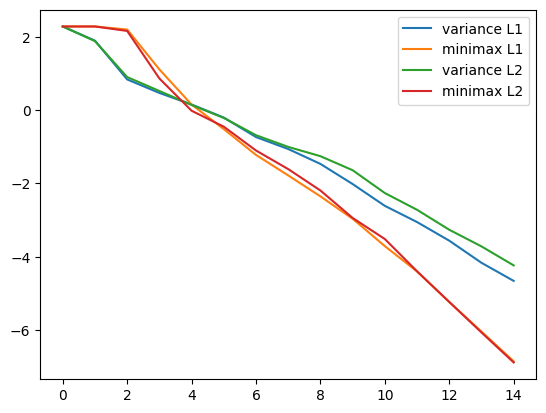

In [2]:
plt.plot(range(15),np.log(vari1),label='variance L1')
plt.plot(range(15),np.log(mini1),label='minimax L1')
plt.plot(range(15),np.log(vari2),label='variance L2')
plt.plot(range(15), np.log(mini2),label='minimax L2')
plt.legend()
plt.show()